##### Set up packages and directories

In [60]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
import copy
from joblib import Parallel, delayed
import os
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML

In [61]:
project_dir = 'D:/Project_Data/Project_6'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
output_dir = project_dir + '/Output'
refseq_dir = 'D:/Tests/NCBI_Dataset_Mycobacteria'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [62]:
species_list = util.list_dirs(refseq_dir)
reference_species = 'GCF_000195955.2'
print(len(species_list))

10


##### Translation function

In [63]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]
def translate_sequence(input_seq, strand, rf):
    output_seq = ''
    if strand == 1:
        seq = input_seq[rf:]
    else:
        seq = align.reverse_complement(input_seq)[rf:]
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

In [64]:
def translate_orf(sequence, start, end, strand):
    return translate_sequence(sequence[start:end], strand, 0)              

##### Output nt sequences in FASTA format

In [65]:
def produce_blast_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[1]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

##### Function to find maximal open reading frame between two co-ordinates with mutation probability less than defined p-value

In [66]:
def find_all_maximal_orfs(sequence, seq_start, seq_stop, output_all_orfs = False, min_orf_length = 0):
    max_len = 0
    orfs_found = []
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for rf in range(3):
            i = rf
            while i < seq_len - 2:
                orf_length = 0
                test_codon = temp[i: i+3] 
                if test_codon in ['ATG','GTG','TTG']:  
                    for j in range(i + 3, seq_len - 2, 3):
                        test_codon_2 = temp[j: j+3] 
                        if test_codon_2 in ['TAG','TGA','TAA']:
                            orf_length = j - i
                            break
                            
                if orf_length > 0:
                    if frame == 'Forward':
                        orf_start =  seq_start + i
                        orf_end = seq_start + j+3
                        orf_strand = 1
                    else:
                        orf_start =  seq_start + seq_len-(j+3)
                        orf_end = seq_start + seq_len-i
                        orf_strand = -1
                    
                    if orf_length >= min_orf_length:
                        orfs_found.append((orf_start, orf_end, orf_strand, orf_length))

                if orf_length > max_len and orf_length >= min_orf_length:                                           
                    max_len = orf_length
                    start_pos = orf_start
                    end_pos = orf_end
                    strand = orf_strand 

                if orf_length > 0:
                    i = j
                else:
                    i +=3
    if output_all_orfs == True:
        sorted_orfs = sorted(orfs_found, key=lambda x: x[3], reverse=True)
        return sorted_orfs                
    elif start_pos == -999:
        return(0,0,0,0)
    else:
        return(start_pos, end_pos, strand, max_len)   

##### Extract full sequences from each organism and create directory of start and stops for each annotated cds (use Mycobrowser for MTb)

In [67]:
full_sequences = []
cds_boundary_dict = {}
mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
for i, species in tqdm(enumerate(species_list)):
    temp = []
    genome_record = next(SeqIO.parse(genome_datasets_dir + '/'+species+'/genomic.gbff', "genbank"))
    full_sequences.append(str(genome_record.seq))
    if species == reference_species:
        reference_species_index = i
        temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Function']]      #Just CDS
        for i, r in temp_cds.iterrows():
            if r['Strand'] == '+':
                strand = 1
            else:
                strand = -1
            temp.append((r['Locus'],r['Start']-1, r['Stop'], strand))
    else:
        for feature in genome_record.features:
                a = feature.qualifiers
                if a.get("locus_tag")!= None and feature.type == 'CDS':
                    locus_tag = a.get("locus_tag")[0]
                    temp.append([locus_tag, int(feature.location.start), int(feature.location.end), int(feature.location.strand)])
    cds_boundary_dict[species] = temp

0it [00:00, ?it/s]

##### Find maximal ORFs in all frames for each species

In [175]:
maximal_orfs = []
for i, sequence in enumerate(tqdm(full_sequences)):
    print(species_list[i])
    maximal_orfs.append(find_all_maximal_orfs(sequence, 0, len(sequence), True, 30))

  0%|          | 0/10 [00:00<?, ?it/s]

GCF_000157895.3
GCF_000195955.2
GCF_001655245.1
GCF_002285675.1
GCF_010727945.1
GCF_010730055.1
GCF_010731535.1
GCF_016745295.1
GCF_900603025.1
NC_008596.1


##### Eliminate mORFs which overlap with CDS

In [215]:
non_overlapping_maximal_orfs = []
for i, species in tqdm(enumerate(species_list)):
    temp = []
    for orf in maximal_orfs[i]:
        overlap = False
        for cds in cds_boundary_dict[species]:
            if min(cds[2], orf[1]) - max(cds[1], orf[0]) > 0.1 * (orf[1] - orf[0]):
                overlap = True
                break
        if overlap == False:
            temp.append(orf)
    non_overlapping_maximal_orfs.append(temp)

0it [00:00, ?it/s]

In [216]:
len(non_overlapping_maximal_orfs[1])

5633

###### Output two blast files - one (subject) containing all translated mORFs, the other (query) just the ones for the reference species 

In [217]:
subject_dicts = []
subject_proteins = []

for j, orf_list in enumerate(maximal_orfs):
    temp_dict = {}
    for i, orf in enumerate(orf_list):
        temp = translate_orf(full_sequences[j], orf[0], orf[1], orf[2])
        subject_proteins.append([species_list[j]+'_'+str(i), temp[:-1]])
        temp_dict[species_list[j]+'_'+str(i)] = orf
    subject_dicts.append(temp_dict)
produce_blast_file(subject_proteins, refseq_dir + '/subject_proteins.faa')


query_dict = {}
query_proteins = []
for i, orf in enumerate(non_overlapping_maximal_orfs[reference_species_index]):
    temp = translate_orf(full_sequences[reference_species_index], orf[0], orf[1], orf[2])
    query_proteins.append([species_list[reference_species_index]+'_'+str(i), temp[:-1]])
    query_dict[species_list[reference_species_index]+'_'+str(i)] = orf

produce_blast_file(query_proteins, refseq_dir + '/query_proteins.faa')


  0%|          | 0/824168 [00:00<?, ?it/s]

  0%|          | 0/5633 [00:00<?, ?it/s]

In [218]:
morf_subject_details_dict = {}
for i, species in tqdm(enumerate(species_list)):
    for k, orf in subject_dicts[i].items():
        morf_subject_details_dict[k] = [orf]
        for cds in cds_boundary_dict[species]:
            if orf[0] <= cds[1] and orf[1] >= cds[2] and orf[2] == cds[3] and (orf[0]-cds[1])%3 == 0:
                morf_subject_details_dict[k].append(cds)

morf_query_details_dict = {}
for k, orf in query_dict.items():
    morf_query_details_dict[k] = [orf]
    for cds in cds_boundary_dict[species]:
        if orf[0] <= cds[1] and orf[1] >= cds[2] and orf[2] == cds[3] and (orf[0]-cds[1])%3 == 0:
            morf_query_details_dict[k].append(cds)

0it [00:00, ?it/s]

##### Create blast database

In [219]:
if 1==1:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\Tests\\NCBI_Dataset_Mycobacteria & makeblastdb -in subject_proteins.faa -dbtype prot -out max_prot', shell=True, capture_output = True)
    os.chdir(w_d)

In [220]:
if 1==1:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\BLAST\\maxprot & blastp -query d:\\Tests\\NCBI_Dataset_Mycobacteria\\query_proteins.faa -db max_prot -out blastp_results.csv -evalue 1e-7 -seg no -outfmt "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send sstrand evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    os.chdir(w_d)

In [221]:
blast_results = pd.read_csv("D:\\BLAST\\maxprot\\blastp_results.csv", header = None)
blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'subject_strand', 'e_value', 'bit_score']

In [222]:
blast_results = blast_results.query('subject_length == subject_end_alignment and query_length == query_end_alignment')
blast_results['query_info']=  blast_results['query_accession_ver'].map(morf_query_details_dict)
blast_results['subject_info']=  blast_results['subject_accession_ver'].map(morf_subject_details_dict)

In [223]:
for i, r in blast_results.iterrows():
    blast_results.at[i, 'query_species'] = '_'.join(r.query_accession_ver.split('_')[:-1])
    blast_results.at[i, 'subject_species'] = '_'.join(r.subject_accession_ver.split('_')[:-1])
blast_results = blast_results.query('not (query_species == subject_species)')

In [224]:
for i, r in blast_results.iterrows():
    blast_results.at[i, 'query_species'] = '_'.join(r.query_accession_ver.split('_')[:-1])
    blast_results.at[i, 'subject_species'] = '_'.join(r.subject_accession_ver.split('_')[:-1])
    if len(r.query_info) > 1:
        blast_results.at[i, 'annotated_cds_in_query'] = 'Y'
    else:
        blast_results.at[i, 'annotated_cds_in_query'] = 'N'
    if len(r.subject_info) > 1:
        blast_results.at[i, 'annotated_cds_in_subject'] = 'Y'
    else:
        blast_results.at[i, 'annotated_cds_in_subject'] = 'N'
    if r.query_info[0][2] == 1:
        blast_results.at[i, 'query_start_pos'] = r.query_info[0][0] + (r.query_start_alignment - 1) * 3
        blast_results.at[i, 'query_end_pos'] = r.query_info[0][0] + (r.query_end_alignment - 1) * 3 + 6 # doesn't include stop codon in blast
    else:
        blast_results.at[i, 'query_start_pos'] = r.query_info[0][0] + (r.query_end_alignment - r.query_length) * 3
        blast_results.at[i, 'query_end_pos'] = r.query_info[0][1] - (r.query_start_alignment - 1) * 3
       
    if r.subject_info[0][2] == 1:
        blast_results.at[i, 'subject_start_pos'] = r.subject_info[0][0] + (r.subject_start_alignment - 1) * 3
        blast_results.at[i, 'subject_end_pos'] = r.subject_info[0][0] + (r.subject_end_alignment - 1) * 3 + 6 # doesn't include stop codon in blast
    else:
        blast_results.at[i, 'subject_start_pos'] = r.subject_info[0][0] + (r.subject_end_alignment - r.subject_length) * 3
        blast_results.at[i, 'subject_end_pos'] = r.subject_info[0][1] - (r.subject_start_alignment - 1) * 3

In [225]:
blast_results = blast_results.loc[blast_results.groupby(['query_accession_ver','subject_species'])['bit_score'].idxmax()]
for i, r in blast_results.iterrows():
    if len(r['query_info']) > 1:
        blast_results.at[i, 'subject_locus'] = r['query_info'][1][0]
    else:
        blast_results.at[i, 'subject_locus'] = ''

In [226]:
blast_results.to_csv(project_dir + '/temp.csv')

In [227]:
subset_blast_results = blast_results.query('query_species == @reference_species and subject_species == "GCF_010730055.1"')
subset_blast_results.to_csv(project_dir + '/temp2.csv')

<Figure size 1152x1152 with 0 Axes>

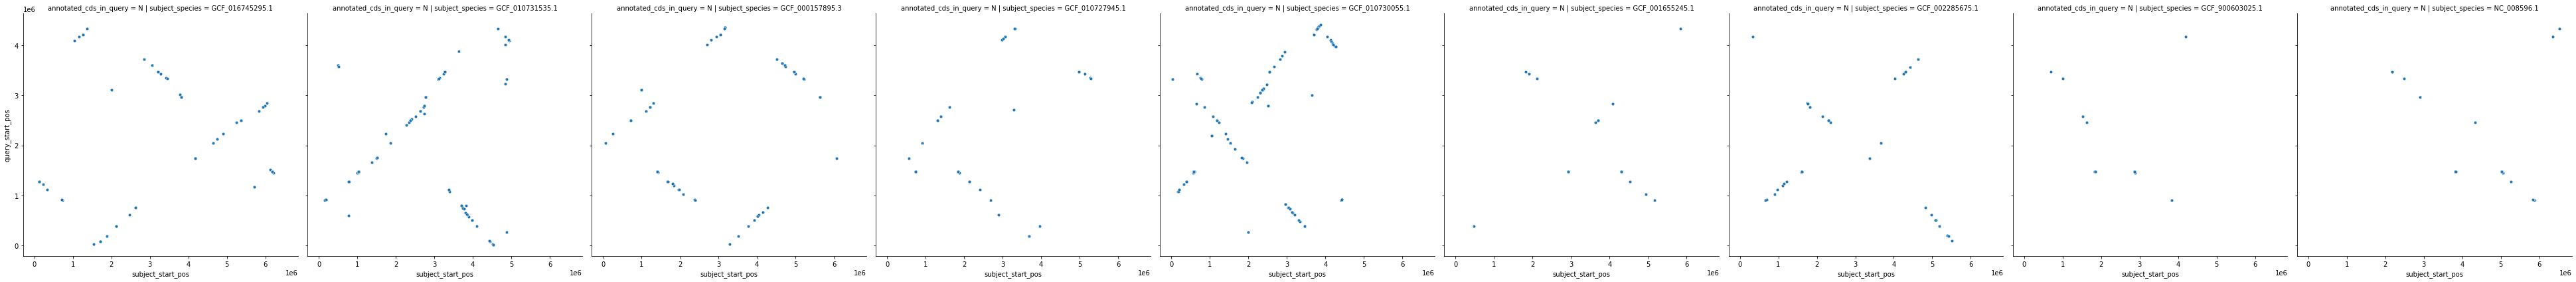

In [230]:
tb_blast_results = blast_results[blast_results.query_species == reference_species]
plt.figure(figsize=(16, 16))
g = sns.FacetGrid(tb_blast_results, col='subject_species', row = 'annotated_cds_in_query', height=6)
g.map(sns.scatterplot, 'subject_start_pos', 'query_start_pos', s=20)
#sns.scatterplot(data = blast_results, y = 'subject_start_pos', x = 'query_start_pos', s=1, hue = 'annotated_cds_in_query')

In [231]:
tb_blast_results.groupby(['subject_species','annotated_cds_in_query']).count()

,,query_accession_ver,subject_accession_ver,query_length,subject_length,percent_identical_matches,alignment_length,number_mismatches,number_of_gap_openings,query_start_alignment,query_end_alignment,...,bit_score,query_info,subject_info,query_species,annotated_cds_in_subject,query_start_pos,query_end_pos,subject_start_pos,subject_end_pos,subject_locus
subject_species,annotated_cds_in_query,,,,,,,,,,,,,,,,,,,,,
GCF_000157895.3,N,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
GCF_001655245.1,N,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
GCF_002285675.1,N,97,97,97,97,97,97,97,97,97,97,...,97,97,97,97,97,97,97,97,97,97
GCF_010727945.1,N,71,71,71,71,71,71,71,71,71,71,...,71,71,71,71,71,71,71,71,71,71
GCF_010730055.1,N,156,156,156,156,156,156,156,156,156,156,...,156,156,156,156,156,156,156,156,156,156
GCF_010731535.1,N,144,144,144,144,144,144,144,144,144,144,...,144,144,144,144,144,144,144,144,144,144
GCF_016745295.1,N,120,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
GCF_900603025.1,N,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
NC_008596.1,N,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60


In [232]:
temp_df = pd.DataFrame(tb_blast_results.groupby(['query_accession_ver', 'annotated_cds_in_query']).count())
temp_df.groupby(['subject_accession_ver','annotated_cds_in_query']).count()

,,query_length,subject_length,percent_identical_matches,alignment_length,number_mismatches,number_of_gap_openings,query_start_alignment,query_end_alignment,subject_start_alignment,subject_end_alignment,...,query_info,subject_info,query_species,subject_species,annotated_cds_in_subject,query_start_pos,query_end_pos,subject_start_pos,subject_end_pos,subject_locus
subject_accession_ver,annotated_cds_in_query,,,,,,,,,,,,,,,,,,,,,
1,N,96,96,96,96,96,96,96,96,96,96,...,96,96,96,96,96,96,96,96,96,96
2,N,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
3,N,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
4,N,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
5,N,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
6,N,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
7,N,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
8,N,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
9,N,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27


In [173]:
translate_orf(full_sequences[1], 3297836,3298475,-1)

'PIWELSLTEPGSGVRAQRDDLSASNMTIAGGNDGGATLRERLVALRQERQRLVVDAVCAEAAKMLGEPDPWSVDQDLAFSELGFDSQMTVTLCKRLAAVTGLRLPETVGWDYGSISGLAQYLEAELAGGHGRLKSAGPVNSGATGLWAIEEQLNKVEELVAVIADGEKQRVADRLRALLGTIAGSEAGLGKLIQAASTPDEIFQLIDSELGK*'

In [174]:
translate_orf(full_sequences[5], 1713749,1714328,-1)

'PLWREFITRPARRVLDATDAAASVSDLVTRLHALAPEQRHRELVELVSHSAATVLGRSSTGDIDSHKSFQDLGFDSLTAVELRNRLNTATGLTLSPTLIFDYPTPNILAQHLDGQLKATAVTANEPHLVARIDDLIGELQTLLAQPELSPDDKARLADRVRSLLANPKPEDHDITTATESQLFAIIDEELGS*'

In [172]:
translate_orf(full_sequences[1], 3209405, 3211742,-1)

'YVEAVRWQRSAASRDVLADYDEQAVTVAPRKREAAGVRAVMVSLQRGMQQMGALRTAAALARLNQRNGFDCPGCAWPEEPGGRKLAEFCENGAKAVAEEATKRTVTAEFFARHSVAELSAKPEYWLSQQGRLAHPMVLRPGDDHYRPISWDAAYQLIAEQLNGLDSPDRAVFYTSGRTSNEAAFCYQLLVRSFGTNNLPDCSNMCHESSGAALTDSIGIGKGSVTIGDVEHADLIVIAGQNPGTNHPRMLSVLGKAKANGAKIIAVNPLPEAGLIRFKDPQKVNGVVGHGIPIADEFVQIRLGGDMALFAGLGRLLLEAEERVPGSVVDRSFVDNHCAGFDGYRRRTLQVGLDTVMDATGIELAQLQRVAAMLMASQRTVICWAMGLTQHAHAVATIGEVTNVLLLRGMIGKPGAGVCPVRGHSNVQGDRTMGIWEKMPEQFLAALDREFGITSPRAHGFDTVAAIRAMRDGRVSVFMGMGGNFASATPDTAVTEAALRRCALTVQVSTKLNRSHLVHGATALILPTLGRTDRDTRNGRKQLVSVEDSMSMVHLSRGSLHPPSDQVRSEVQIICQLARALFGPGHPVPWERFADDYDTIRDAIAAVVPGCDDYNHKVRVPDGFQLPHPPRDAREFRTSTGKANFAVNPLQWVPVPPGRLVLQTLRSHDQYNTTIYGLDDRYRGVKGGRRVVFINPADIETFGLTAGDRVDLVSEWTDGQGGLQERRAKDFLVVAYSTPVGNAAAYYPETNPLVPLDHTAAQSNTPVSKAIIVRLEPTA*'